<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_02_imbalanced_data_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Class Imbalance in Machine Learning

**Class imbalance** refers to a situation in a classification problem where the number of instances in different classes is significantly disproportionate. In other words, one class (the majority class) has many more instances than the other class (the minority class).

#### Key Points about Class Imbalance:

1. **Prevalence**:
   - Class imbalance is common in many real-world datasets. Examples include fraud detection (where fraudulent transactions are rare), medical diagnosis (where certain diseases have low prevalence), and spam detection (where spam emails are much fewer than legitimate ones).

2. **Impact on Model Performance**:
   - **Bias Toward Majority Class**: Many machine learning algorithms assume that the classes are balanced. When they are not, the model may become biased toward the majority class, resulting in high accuracy but poor performance on the minority class.
   - **Misleading Metrics**: Accuracy becomes a misleading metric in imbalanced datasets. A model that always predicts the majority class can achieve high accuracy but fails to correctly identify the minority class.
   - **Poor Generalization**: The model might fail to generalize well to unseen data, especially in correctly identifying instances of the minority class.

3. **Performance Metrics for Imbalanced Data**:
   - **Precision**: The proportion of true positives among all predicted positives. Useful when the cost of false positives is high.
   - **Recall (Sensitivity)**: The proportion of true positives among all actual positives. Useful when the cost of false negatives is high.
   - **F1 Score**: The harmonic mean of precision and recall. Provides a balanced measure, especially useful for imbalanced datasets.
   - **ROC-AUC**: Measures the ability of the model to distinguish between classes. The area under the ROC curve (AUC) provides an aggregate measure of performance across all classification thresholds.
   - **Precision-Recall AUC**: Particularly useful for highly imbalanced datasets, focusing on the performance with respect to the minority class.

4. **Techniques to Address Class Imbalance**:
   - **Resampling Techniques**:
     - **Oversampling**: Increasing the number of instances in the minority class. Techniques include Random Oversampling and Synthetic Minority Over-sampling Technique (SMOTE).
     - **Undersampling**: Reducing the number of instances in the majority class. Techniques include Random Undersampling and NearMiss.
   - **Algorithmic Approaches**:
     - **Cost-sensitive Learning**: Assigning different misclassification costs to classes, penalizing the misclassification of the minority class more heavily.
     - **Anomaly Detection Models**: Treating the minority class as anomalies and using specialized models designed for anomaly detection.
   - **Ensemble Methods**:
     - **Balanced Random Forest**: Combining multiple decision trees with resampling to create balanced datasets for each tree.
     - **EasyEnsemble and BalanceCascade**: Combining boosting with undersampling techniques.

5. **Threshold Adjustment**:
   - Adjusting the decision threshold of the classifier to better capture the minority class. For example, lowering the threshold can increase the recall for the minority class at the expense of precision.



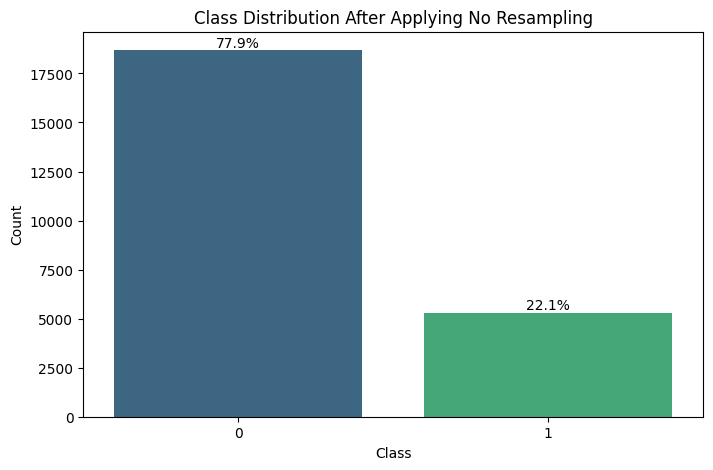

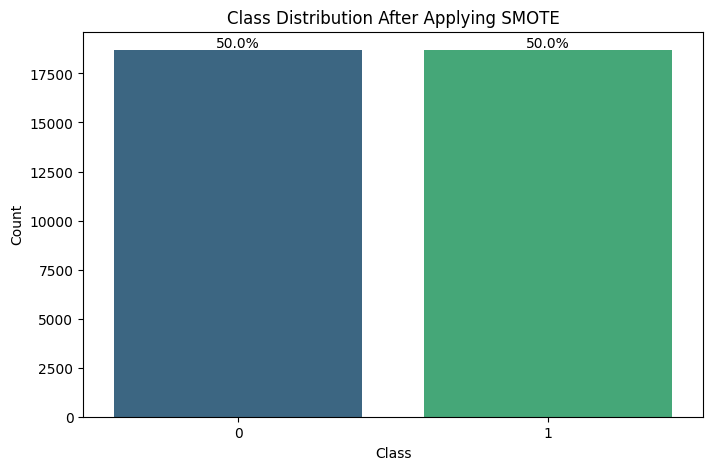

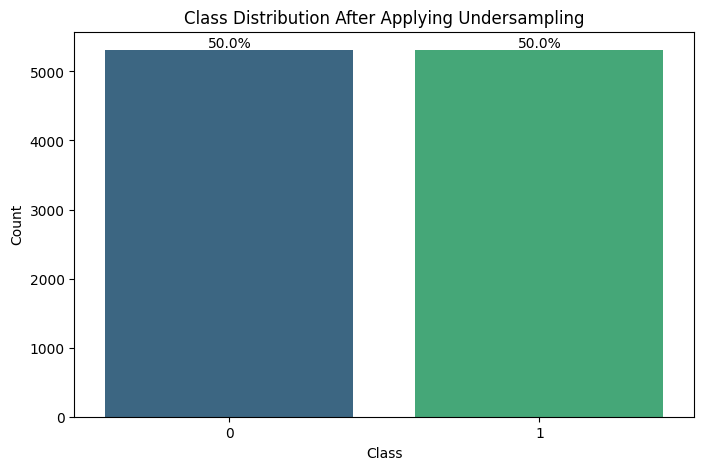

<Figure size 1200x800 with 0 Axes>

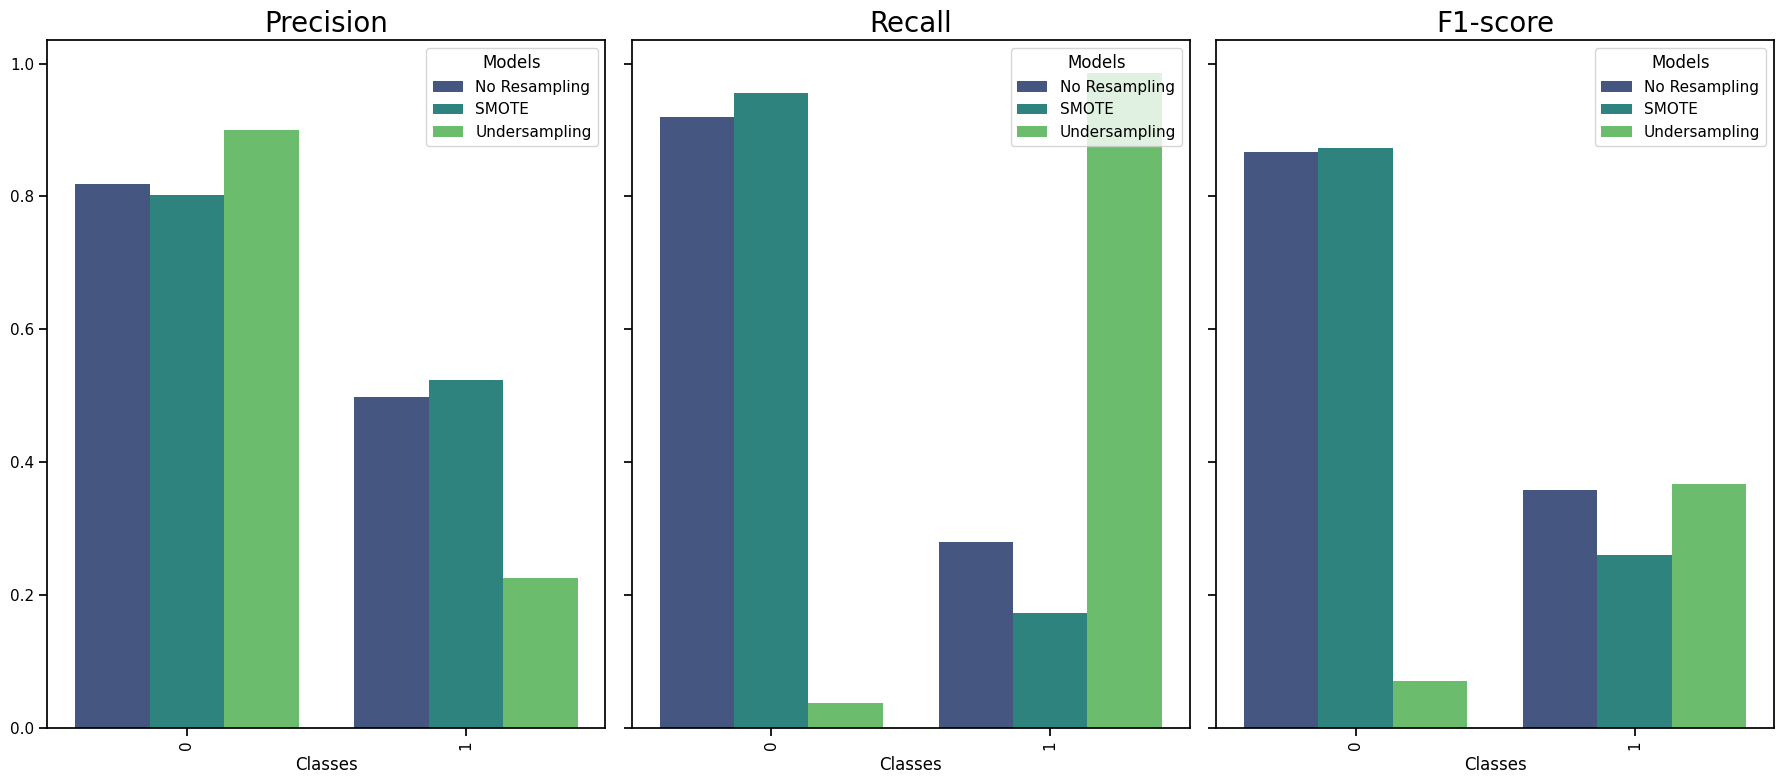

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data
from model_pipeline import SklearnSimpleNN, train_model
import torch

# Function to convert DataFrames to tensors
def convert_to_tensors(X, y):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    return X_tensor, y_tensor

# Function to apply SMOTE
def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to apply undersampling
def apply_undersampling(X_train, y_train):
    undersampler = RandomUnderSampler(random_state=42)
    X_train_res, y_train_res = undersampler.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Generalized function to plot class distribution after sampling
def plot_class_distribution_after_sampling(y_train_res, sampling_type):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train_res, hue=y_train_res, palette='viridis', dodge=False, legend=False)
    plt.title(f'Class Distribution After Applying {sampling_type}')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Calculate the percentage for each class
    total = len(y_train_res)
    class_counts = y_train_res.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

# Function to train and evaluate the model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, class_weights=None):
    input_dim = X_train.shape[1]
    if class_weights is None:
        class_weights = [1.0, 1.0]

    nn_estimator = SklearnSimpleNN(input_dim=input_dim, pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train, y_train)
    y_pred = nn_estimator.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    return report, y_pred

# Function to plot multiple classification reports
def plot_multiple_classification_reports(y_trues, y_preds, model_names, metrics=['precision', 'recall', 'f1-score'], palette="viridis"):
    reports = []
    for y_true, y_pred, model_name in zip(y_trues, y_preds, model_names):
        # Generate classification report
        report = classification_report(y_true, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        # Drop the non-class rows
        report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
        report_df['model'] = model_name
        reports.append(report_df)

    # Combine all reports into a single DataFrame
    combined_report = pd.concat(reports).reset_index().rename(columns={'index': 'class'})

    # Plot the results for each metric
    sns.set_context('notebook')
    plt.figure(figsize=(12, 8))
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 8), sharey=True)
    for ax, metric in zip(axes, metrics):
        sns.barplot(data=combined_report, x='class', y=metric, hue='model', palette=palette, ax=ax)
        ax.set_title(f'{metric.capitalize()}', fontsize=20)
        ax.set_xlabel('Classes')
        # ax.set_ylabel(metric.capitalize())
        ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=90)
        ax.legend(title='Models', loc='upper right')

    plt.tight_layout()
    plt.show()

# Function to apply resampling and plot class distribution
def apply_resampling_and_plot(X_train, y_train):
    # No Resampling
    plot_class_distribution_after_sampling(y_train, "No Resampling")

    # Apply SMOTE
    X_train_smote, y_train_smote = apply_smote(X_train, y_train)
    plot_class_distribution_after_sampling(y_train_smote, "SMOTE")

    # Apply Undersampling
    X_train_under, y_train_under = apply_undersampling(X_train, y_train)
    plot_class_distribution_after_sampling(y_train_under, "Undersampling")

    return (X_train, y_train), (X_train_smote, y_train_smote), (X_train_under, y_train_under)

# Function to train and evaluate models
def train_and_evaluate_models(X_train_sets, y_train_sets, X_test, y_test):
    reports = []
    y_preds = []

    for X_train, y_train in zip(X_train_sets, y_train_sets):
        X_train_tensor, y_train_tensor = convert_to_tensors(X_train, y_train)
        X_test_tensor, y_test_tensor = convert_to_tensors(X_test, y_test)
        report, y_pred = train_and_evaluate_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
        reports.append(report)
        y_preds.append(y_pred)

    return reports, y_preds

# Function to gather reports and predictions into DataFrame
def gather_reports_and_predictions(reports, y_trues, y_preds, model_names):
    combined_report = pd.concat(
        [pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore').assign(model=model_name) for report, model_name in zip(reports, model_names)]
    ).reset_index().rename(columns={'index': 'class'})

    return combined_report

# Main function to load data and call other functions
def main(url, categorical_columns, target):
    # Load and preprocess data
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)

    # Apply resampling and plot class distribution
    (X_train, y_train), (X_train_smote, y_train_smote), (X_train_under, y_train_under) = apply_resampling_and_plot(X_train, y_train)

    # Train and evaluate models
    X_train_sets = [X_train, X_train_smote, X_train_under]
    y_train_sets = [y_train, y_train_smote, y_train_under]
    reports, y_preds = train_and_evaluate_models(X_train_sets, y_train_sets, X_test, y_test)

    # Gather reports and predictions
    model_names = ['No Resampling', 'SMOTE', 'Undersampling']
    combined_report = gather_reports_and_predictions(reports, [y_test]*3, y_preds, model_names)

    # Plot multiple classification reports
    plot_multiple_classification_reports([y_test]*3, y_preds, model_names)

    return combined_report

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Run the main function
combined_report = main(url, categorical_columns, target)


In the context of fraud detection, **recall (sensitivity)** is generally considered more important than precision. Here’s why:

### Importance of Recall in Fraud Detection

1. **High Cost of Missing Fraudulent Transactions**:
   - In fraud detection, the primary goal is to identify as many fraudulent transactions as possible. Missing a fraudulent transaction (false negative) can lead to significant financial losses and potential reputational damage. Therefore, having a high recall ensures that most fraudulent transactions are detected.

2. **Accepting Some False Positives**:
   - While false positives (legitimate transactions flagged as fraudulent) can be inconvenient and may require additional verification steps, the consequences are typically less severe than missing a fraudulent transaction. Companies can manually review flagged transactions to confirm their legitimacy, which is a manageable process.

3. **Safety Net**:
   - Ensuring that most fraud cases are caught, even at the expense of some false alarms, provides a safety net that is crucial for protecting financial assets and maintaining customer trust.

### Balancing Precision and Recall

However, it’s important to find a balance that suits the specific context and resources available. Excessive false positives can lead to customer dissatisfaction and increased operational costs due to manual reviews. Therefore, while recall is prioritized, precision should not be completely disregarded.

### Practical Approach in Fraud Detection

1. **Adjusting the Threshold**:
   - As mentioned earlier, adjusting the decision threshold can help balance recall and precision. Lowering the threshold increases recall but may reduce precision.

2. **Using Evaluation Metrics**:
   - **F1 Score**: The F1 score, which is the harmonic mean of precision and recall, can be a useful metric to find a balance. However, if recall is the priority, you might focus more on maximizing recall even if the F1 score is slightly lower.

3. **Implementing Resampling Techniques**:
   - Techniques like SMOTE or balanced random forests can help improve model performance on the minority class.

4. **Post-Processing**:
   - Implementing rules or secondary models to review flagged transactions can help manage false positives. For example, flagging transactions for manual review if they fall into a certain range of probabilities.




In [2]:
combined_report

,class,precision,recall,f1-score,support,model
0,0.0,0.817957,0.920180,0.866062,4673.0,No Resampling
1,1.0,0.497981,0.278824,0.357488,1327.0,No Resampling
2,0.0,0.802698,0.955061,0.872276,4673.0,SMOTE
3,1.0,0.522727,0.173323,0.260328,1327.0,SMOTE
4,0.0,0.900000,0.036593,0.070327,4673.0,Undersampling
5,1.0,0.225129,0.985682,0.366541,1327.0,Undersampling


Based on the results, we can interpret the performance of the different resampling methods with a focus on recall, which is our priority for default loan data.

### Interpretation

1. **No Resampling**:
   - **Class 0 (Non-Default)**: Precision: 0.818, Recall: 0.920, F1-Score: 0.866
   - **Class 1 (Default)**: Precision: 0.498, Recall: 0.279, F1-Score: 0.357
   - **Recall for Default Class**: 0.279

2. **SMOTE**:
   - **Class 0 (Non-Default)**: Precision: 0.803, Recall: 0.955, F1-Score: 0.872
   - **Class 1 (Default)**: Precision: 0.523, Recall: 0.173, F1-Score: 0.260
   - **Recall for Default Class**: 0.173

3. **Undersampling**:
   - **Class 0 (Non-Default)**: Precision: 0.900, Recall: 0.037, F1-Score: 0.070
   - **Class 1 (Default)**: Precision: 0.225, Recall: 0.986, F1-Score: 0.367
   - **Recall for Default Class**: 0.986

### Recommendation

Given our priority on recall for the default loan class (Class 1), the undersampling method is the best option. Here’s why:

- **Recall for Class 1**: The recall for Class 1 (default) is the highest with undersampling, reaching 0.986. This means that undersampling is able to identify nearly all of the default cases correctly, which is critical for our application where missing a default case can be very costly.

### Considerations

- **Precision for Class 1**: The precision for Class 1 with undersampling is 0.225, which is quite low. This indicates a high number of false positives. While recall is our priority, the low precision means we will have many instances incorrectly identified as defaults. This can lead to unnecessary actions being taken on non-default cases.
- **Class 0 Performance**: The performance for Class 0 (non-default) drops significantly with undersampling, with a recall of only 0.037. This means that the model will miss a large number of non-default cases.

### Final Recommendation

Given the high recall for the default class with undersampling, it seems to be the best choice considering our priority. However, you should also be aware of the trade-offs, particularly the low precision and poor performance for the non-default class. Depending on the cost and impact of false positives in your application, you might need to balance these factors or consider additional strategies such as combining resampling methods or using ensemble methods to improve the overall performance.

**Undersampling is recommended due to its high recall for the default class, but be mindful of the trade-offs in precision and non-default class performance.**

In [3]:
# Function to be added to smote_sampling_metrics_comparison.py
script_content = """
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data
from model_pipeline import SklearnSimpleNN, train_model
import torch

# Function to convert DataFrames to tensors
def convert_to_tensors(X, y):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    return X_tensor, y_tensor

# Function to apply SMOTE
def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Function to apply undersampling
def apply_undersampling(X_train, y_train):
    undersampler = RandomUnderSampler(random_state=42)
    X_train_res, y_train_res = undersampler.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Generalized function to plot class distribution after sampling
def plot_class_distribution_after_sampling(y_train_res, sampling_type):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train_res, hue=y_train_res, palette='viridis', dodge=False, legend=False)
    plt.title(f'Class Distribution After Applying {sampling_type}')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Calculate the percentage for each class
    total = len(y_train_res)
    class_counts = y_train_res.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

# Function to train and evaluate the model
def train_and_evaluate_model(X_train, y_train, X_test, y_test, class_weights=None):
    input_dim = X_train.shape[1]
    if class_weights is None:
        class_weights = [1.0, 1.0]

    nn_estimator = SklearnSimpleNN(input_dim=input_dim, pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train, y_train)
    y_pred = nn_estimator.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    return report, y_pred

# Function to plot multiple classification reports
def plot_multiple_classification_reports(y_trues, y_preds, model_names, metrics=['precision', 'recall', 'f1-score'], palette="viridis"):
    reports = []
    for y_true, y_pred, model_name in zip(y_trues, y_preds, model_names):
        # Generate classification report
        report = classification_report(y_true, y_pred, output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        # Drop the non-class rows
        report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
        report_df['model'] = model_name
        reports.append(report_df)

    # Combine all reports into a single DataFrame
    combined_report = pd.concat(reports).reset_index().rename(columns={'index': 'class'})

    # Plot the results for each metric
    sns.set_context('notebook')
    plt.figure(figsize=(12, 8))
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 8), sharey=True)
    for ax, metric in zip(axes, metrics):
        sns.barplot(data=combined_report, x='class', y=metric, hue='model', palette=palette, ax=ax)
        ax.set_title(f'{metric.capitalize()}', fontsize=20)
        ax.set_xlabel('Classes')
        # ax.set_ylabel(metric.capitalize())
        ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=90)
        ax.legend(title='Models', loc='upper right')

    plt.tight_layout()
    plt.show()

# Function to apply resampling and plot class distribution
def apply_resampling_and_plot(X_train, y_train):
    # No Resampling
    plot_class_distribution_after_sampling(y_train, "No Resampling")

    # Apply SMOTE
    X_train_smote, y_train_smote = apply_smote(X_train, y_train)
    plot_class_distribution_after_sampling(y_train_smote, "SMOTE")

    # Apply Undersampling
    X_train_under, y_train_under = apply_undersampling(X_train, y_train)
    plot_class_distribution_after_sampling(y_train_under, "Undersampling")

    return (X_train, y_train), (X_train_smote, y_train_smote), (X_train_under, y_train_under)

# Function to train and evaluate models
def train_and_evaluate_models(X_train_sets, y_train_sets, X_test, y_test):
    reports = []
    y_preds = []

    for X_train, y_train in zip(X_train_sets, y_train_sets):
        X_train_tensor, y_train_tensor = convert_to_tensors(X_train, y_train)
        X_test_tensor, y_test_tensor = convert_to_tensors(X_test, y_test)
        report, y_pred = train_and_evaluate_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
        reports.append(report)
        y_preds.append(y_pred)

    return reports, y_preds

# Function to gather reports and predictions into DataFrame
def gather_reports_and_predictions(reports, y_trues, y_preds, model_names):
    combined_report = pd.concat(
        [pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore').assign(model=model_name) for report, model_name in zip(reports, model_names)]
    ).reset_index().rename(columns={'index': 'class'})

    return combined_report

# Main function to load data and call other functions
def main(url, categorical_columns, target):
    # Load and preprocess data
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)

    # Apply resampling and plot class distribution
    (X_train, y_train), (X_train_smote, y_train_smote), (X_train_under, y_train_under) = apply_resampling_and_plot(X_train, y_train)

    # Train and evaluate models
    X_train_sets = [X_train, X_train_smote, X_train_under]
    y_train_sets = [y_train, y_train_smote, y_train_under]
    reports, y_preds = train_and_evaluate_models(X_train_sets, y_train_sets, X_test, y_test)

    # Gather reports and predictions
    model_names = ['No Resampling', 'SMOTE', 'Undersampling']
    combined_report = gather_reports_and_predictions(reports, [y_test]*3, y_preds, model_names)

    # Plot multiple classification reports
    plot_multiple_classification_reports([y_test]*3, y_preds, model_names)

    return combined_report

# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Run the main function
combined_report = main(url, categorical_columns, target)

"""

# Append the function to model_pipeline.py
with open("resampling_utils.py.py", "a") as file:
    file.write(script_content)

print("Function appended successfully to resampling_utils.py.py")

Function appended successfully to resampling_utils.py.py


#### Standardize Report

- Reformat Report for Comparison to Other Resampling Mehtods in other notbeooks

In [ ]:
# Ensure the DataFrame has the same columns and format as the new results
df_previous_smote = df_previous_smote[['class', 'precision', 'recall', 'f1-score', 'resampling']]

# Ensure the columns have the same names and order
df_previous_smote.rename(columns={'resampling': 'resampling', 'class': 'class', 'precision': 'precision', 'recall': 'recall', 'f1-score': 'f1-score'}, inplace=True)


In [ ]:
# Save the combined_report to a CSV file
combined_report.to_csv("resampling_comparison_results_SMOTEEN.csv", index=False)